In [36]:
import sys
if 'analysis_functions_seq_5D_cc' in sys.modules:
    del sys.modules["analysis_functions_seq_5D_cc"]

from analysis_functions_seq_5D_cc import *
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import time
from astropy.io import ascii
from os import path
import pandas as pd
import os
from os import path


In [44]:
path_results ='results/'
if path.exists(path_results) == False:
    os.mkdir(path_results)

if path.exists(path_results+'plots_metrics') == False:
    os.mkdir(path_results+'plots_metrics')
    os.mkdir(path_results+'plots_samples')
    os.mkdir(path_results+'plots_CMD')
    os.mkdir(path_results+'catalogs')


In [10]:
# These are the parameters that I have used for the analysis!!!!
algorithm = 'svc'
mem_prob_threshold= 0.7
prob_non_mem = 0.02
multi_var_type = 'lit'
fraction_pool_NM = 0.1
limit_sigma = 5.
n_iterations_probab = 1000

cluster_name = 'Blanco_1'

In [5]:
###### Load clusters' tables
all_clusters, all_cl_members = load_cluster_tables('CantatGaudin20.fits','noDuplicates_allmembers.csv')


In [8]:
results=def_results()

In [15]:
name_model = cluster_name+'__'+algorithm+'_'+str(mem_prob_threshold)+'_'+str(prob_non_mem)+'_'+multi_var_type+'_'+str(fraction_pool_NM)+'_'+str(limit_sigma)+'_'+str(n_iterations_probab)
print(name_model)
results['model'].append(name_model)


Blanco_1__svc_0.7_0.02_lit_0.1_5.0_1000


In [14]:
data = Table.from_pandas(pd.read_pickle(cluster_name+'.pkl').drop(columns=['random_index','phot_bp_mean_mag', 'radial_velocity', 'radial_velocity_error']))


In [16]:
###### Find cluster parameters
cl_par = cluster_parameters(all_clusters,cluster_name)
results['cluster'].append(cluster_name)
results['ra'].append(cl_par[0])
results['dec'].append(cl_par[1])
results['plx'].append(cl_par[2])
results['s_plx'].append(cl_par[3])
results['pmra'].append(cl_par[4])
results['s_pmra'].append(cl_par[5])
results['pmdec'].append(cl_par[6])
results['s_pmdec'].append(cl_par[7])
results['r50'].append(cl_par[8])


Blanco_1
Plx: 4.210000038146973 +/- 0.12099999934434891
pmra: 18.73900032043457 +/- 0.4320000112056732
pmdec: 2.6019999980926514 +/- 0.4440000057220459
----


In [17]:
###### Clean dataframe
data_clean = clean_database(data,cl_par,limit_sigma,all_cl_members,cluster_name)
data_clean['membership'] = data_clean['membership'].astype("int8")
data_clean['prob_membership'] = data_clean['prob_membership'].astype("float16")
del data


Limits plx: 1.6775625944137573 / 6.6526923179626465
Limits pmra: 16.588396072387695 / 20.851430892944336
Limits pmdec: 0.38694998621940613 / 4.778400897979736
----
All database 75896
All cleaned sample 845


In [18]:
###### Select cluster's members
data_clean, X_members, y_members = mem_selection(data_clean,mem_prob_threshold)
data_clean['Mem_train_test'] = data_clean['membership'].astype("int8")
s_plx_mem = X_members.parallax.std()
s_pmra_mem = X_members.pmra.std()
s_pmdec_mem = X_members.pmdec.std()


Members: 380


In [20]:
###### Select non-members
data_clean, X_nonmembers, y_nonmembers = non_mem_selection(data_clean,cl_par,X_members,prob_non_mem,multi_var_type,fraction_pool_NM)
data_clean['mem_train_test'] = data_clean['membership'].astype("int8")
data_clean['Prob_multivariate_cluster'] = data_clean['membership'].astype("float16")

results['N_mem_train'].append(len(X_members))
results['N_non_mem_train'].append(len(X_nonmembers))


Size selection pool non-members: 377
Non-members: 357


In [21]:
###### Build train and test sets
X_train, y_train, X_test, y_test = build_train_test(X_nonmembers, y_nonmembers,X_members, y_members)


In [22]:
###### Scale features
X_train_std, X_test_std, X_all_std, sc_mod = scale_features(data_clean, X_train, X_test)
del X_train
del X_test


In [32]:
###### Fitting
mod = fitting(algorithm, X_train_std, y_train, X_test_std, y_test, cluster_name, path_results,name_model)


In [34]:
###### Predict for all database
if len(data_clean) < 50000:
    data_clean = calculate_probabilities(data_clean, X_all_std, mod, sc_mod, n_iterations_probab)
else:
    data_clean = calculate_probabilities_chunks(data_clean, X_all_std, mod, sc_mod, n_iterations_probab)
all_mem = data_clean['Probability_median'] >= 0.5


100%|██████████| 845/845 [00:07<00:00, 119.94it/s]


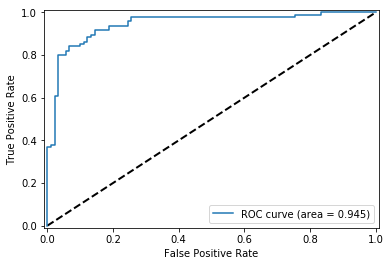

Score 0.8756756756756757
Accuracy 0.8756756756756757
Log Loss 4.294053259768907
ROC AUC 0.9453801169590643
tNM 80, fM 10, fNM 13, tM 82


In [37]:
###### Save metrics
score, accuracy_val, log_loss_val, roc_score, tNM, fM, fNM, tM = calculate_metrics(data_clean,X_test_std,y_test,X_all_std,mod,path_results,name_model)

results['Score'].append(score)
results['Accuracy'].append(accuracy_val)
results['True_NM'].append(tNM)
results['False_M'].append(fM)
results['False_NM'].append(fNM)
results['True_M'].append(tM)
results['LogLoss'].append(log_loss_val)
results['RocScore'].append(roc_score)
mem = data_clean['prob_membership'] >= mem_prob_threshold
results['N_gaia_mem'].append(len(data_clean['prob_membership'][mem]))
all_mem = data_clean['Probability_median'] >= 0.5
results['N_all_mem'].append(len(data_clean['prob_membership'][all_mem]))
non_conf_mem = mem & (data_clean['Probability_median'] < 0.5)
results['N_non_conf_mem'].append(len(data_clean['prob_membership'][non_conf_mem]))


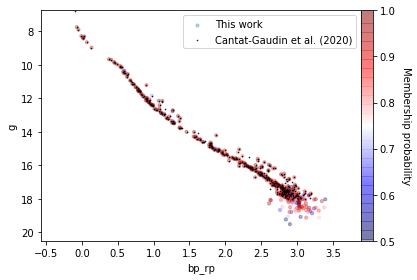

In [38]:
cm = plt.cm.get_cmap('seismic')
sc = plt.scatter(data_clean['bp_rp'][all_mem],data_clean['phot_g_mean_mag'][all_mem], s=10, c=data_clean['Probability_median'][all_mem], vmin=0.5, vmax=1.0, cmap=cm, alpha=0.3, label='This work')
plt.scatter(data_clean['bp_rp'][mem],data_clean['phot_g_mean_mag'][mem], s=0.3, color='black', label='Cantat-Gaudin et al. (2020)')
cbar = plt.colorbar(sc,pad=0.)
cbar.set_label('Membership probability', rotation=270, labelpad=15)
plt.legend()
plt.xlim([data_clean['bp_rp'][all_mem & ~np.isnan(data_clean['bp_rp'])].min()-0.5,data_clean['bp_rp'][all_mem & ~np.isnan(data_clean['bp_rp'])].max()+0.5])
plt.ylim([data_clean['phot_g_mean_mag'][all_mem].max()+1,data_clean['phot_g_mean_mag'][all_mem].min()-1])
plt.ylabel('g')
plt.xlabel('bp_rp')
plt.tight_layout()


In [45]:
df_tosave = data_clean.to_pandas()
df_tosave.to_pickle(path_results+'/catalogs/'+name_model+'_cat_5D.pkl')
del data_clean
del df_tosave


In [48]:
results

OrderedDict([('model', ['Blanco_1__svc_0.7_0.02_lit_0.1_5.0_1000']),
             ('cluster', ['Blanco_1']),
             ('ra', [0.853]),
             ('dec', [-29.958]),
             ('plx', [4.21]),
             ('s_plx', [0.121]),
             ('pmra', [18.739]),
             ('s_pmra', [0.432]),
             ('pmdec', [2.602]),
             ('s_pmdec', [0.444]),
             ('r50', [0.699]),
             ('Score', [0.8756756756756757, 0.8756756756756757]),
             ('Accuracy', [0.8756756756756757, 0.8756756756756757]),
             ('True_NM', [80, 80]),
             ('False_M', [10, 10]),
             ('False_NM', [13, 13]),
             ('True_M', [82, 82]),
             ('LogLoss', [4.294053259768907, 4.294053259768907]),
             ('RocScore', [0.9453801169590643, 0.9453801169590643]),
             ('N_mem_train', [380]),
             ('N_non_mem_train', [357]),
             ('N_gaia_mem', [380, 380]),
             ('N_all_mem', [432, 432]),
             ('N_non_conf_